In [24]:
"""
#Amount google drive
from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/case_study_opti/latent-communication'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))

#!pip install lightning
#!pip install omegaconf
"""

"\n#Amount google drive\nfrom google.colab import drive\nimport os\n\ngdrive_path='/content/gdrive/MyDrive/case_study_opti/latent-communication'\n\n# This will mount your google drive under 'MyDrive'\ndrive.mount('/content/gdrive', force_remount=True)\n# In order to access the files in this notebook we have to navigate to the correct folder\nos.chdir(gdrive_path)\n# Check manually if all files are present\nprint(sorted(os.listdir()))\n\n#!pip install lightning\n#!pip install omegaconf\n"

In [25]:
from pathlib import Path
import torch.nn as nn
import os
import itertools
import torch
import numpy as np
from tqdm import tqdm
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys 

sys.path.append('..')

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

from utils.dataloaders.full_dataloaders import DataLoaderMNIST, DataLoaderFashionMNIST, DataLoaderCIFAR10, DataLoaderCIFAR100
from utils.visualization import (
    visualize_mapping_error,
    visualize_latent_space_pca,
    plot_latent_space,
    highlight_cluster,
)
from utils.model import load_model, get_transformations

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Config:
    def __init__(self, **entries):
        self.__dict__.update(entries)

In [26]:
def clear_memory():
    torch.cuda.empty_cache()

def define_dataloader(file, file2, use_test_set=False):
    if file.strip("_")[0] != file2.strip("_")[0]:
        logging.error("The datasets are different")
    # Define the dataloaders
    name_dataset, name_model, size_of_the_latent, seed = file.strip(".pth").split("_")
    augumentation = get_transformations(name_model)
    if name_dataset.lower() == "mnist":
        dataloader = DataLoaderMNIST(transformation=augumentation, batch_size=64, seed=int(seed))
    if name_dataset.lower() == "fmnist":
        dataloader = DataLoaderFashionMNIST(transformation=augumentation,batch_size=64, seed=int(seed))
    if name_dataset.lower() == "cifar10":
        dataloader = DataLoaderCIFAR10(transformation=augumentation,batch_size=64, seed=int(seed))
    if name_dataset.lower() == "cifar100":
        dataloader = DataLoaderCIFAR100(transformation=augumentation,batch_size=64, seed=int(seed))
    if use_test_set:
        full_dataset_images, full_dataset_labels = dataloader.get_full_test_dataset()
    else:
        full_dataset_images, full_dataset_labels = dataloader.get_full_train_dataset()
    return full_dataset_images, full_dataset_labels, len(np.unique(full_dataset_labels.numpy()))

def load_mapping(path,mapping):
    if mapping == 'Linear':
        from optimization.optimizer import LinearFitting
        mapping = LinearFitting.from_file(path)
    elif mapping == 'Affine':
        from optimization.optimizer import AffineFitting
        mapping = AffineFitting.from_file(path)
    elif mapping == 'NeuralNetwork':
        from optimization.optimizer import NeuralNetworkFitting
        mapping = NeuralNetworkFitting.from_file(path)
    else:
        raise ValueError("Invalid experiment name")
    return mapping

In [28]:
##############################################
#Specify here which files you want to use
results_list = []
folder1 = "../models/checkpoints/VAE/FMNIST/"
folder2 = "../models/checkpoints/VAE/FMNIST/"
dataset="FMNIST"
number_samples = [10,50,100]
mapping_list = ["Affine"]
lamda_list = [0]
sampling_strategy = "equally"
filter = '_8_' #write here if you want that the processed files contain this string (example "_50_" to only process the files with latent size 50)
###############################################
## this autiomatically creates all teh possible setups with the paramenters and the files you speicified, and sets up the correct dataset
files1 = [f for f in os.listdir(folder1) if f.endswith(".pth") and filter in f]
files2 = [f for f in os.listdir(folder2) if f.endswith(".pth") and filter in f]
list_of_files = [(f1, f2) for f1, f2 in itertools.product(files1, files2) if f1 != f2]
combinations_parameters = list(itertools.product(number_samples, mapping_list, lamda_list))
pbar = tqdm(list(itertools.product(list_of_files, combinations_parameters)))
images, labels, n_classes = define_dataloader(files1[0], files2[0], use_test_set=True)
# Get Dictonary for all classes and their respective indexes
class_dict = {i: np.where(labels.numpy() == i)[0] for i in range(n_classes)}
images = images.type(torch.float32)
labels = labels.type(torch.float32)
criterion = nn.MSELoss()

for (file1, file2), (num_samples, mapping_name, lamda) in pbar:
  name_dataset1, name_model1, size_of_the_latent1, seed1 = file1.strip(".pth").split("_")
  name_dataset2, name_model2, size_of_the_latent2, seed2 = file2.strip(".pth").split("_")
  #Load model
  model1 = load_model(model_name=name_model1, name_dataset=name_dataset1, latent_size=int(size_of_the_latent1), seed=int(seed1), model_path = folder1 + file1)
  model2 = load_model(model_name=name_model2, name_dataset=name_dataset2, latent_size=int(size_of_the_latent2), seed=int(seed2), model_path = folder1 + file2)
  #Load mapping
  
  mapping_path = f'../results/transformations/mapping_files/{name_model2}/{file1.strip(".pth")}>{file2.strip(".pth")}>{mapping_name}_{num_samples}_{lamda}_{sampling_strategy}'
  mapping = load_mapping(mapping_path,mapping_name)
  #Calculate latent spaces
  latent_left = model1.get_latent_space(images).detach().cpu().numpy()
  latent_right = model2.get_latent_space(images).detach().cpu().numpy()
  transformed_latent_space = mapping.transform(latent_left)
  #Get stitched output
  decoded_transformed = model2.decode(torch.tensor(transformed_latent_space, dtype=torch.float32).to(images.device)).detach().cpu().numpy()
  mse_loss = criterion(torch.tensor(decoded_transformed),images).item()
  mse_loss_mod1 = criterion(torch.tensor(model1.decode(torch.tensor(latent_left, dtype=torch.float32).to(images.device)).detach().cpu().numpy()),images).item()
  mse_loss_mod2 = criterion(torch.tensor(model2.decode(torch.tensor(latent_right, dtype=torch.float32).to(images.device)).detach().cpu().numpy()),images).item()
  #ssim_loss = ssim(images.detach().cpu().numpy(), decoded_transformed, data_range=decoded_transformed.max() - decoded_transformed.min())
  #psnr_loss = psnr(images.detach().cpu().numpy(), decoded_transformed, data_range=decoded_transformed.max() - decoded_transformed.min())
  for key in class_dict.keys():
    class_indices = class_dict[key]
    class_name = f'{key}'
    decoded_transformed_class = decoded_transformed[class_indices]
    mse_loss_class = criterion(torch.tensor(decoded_transformed_class),images[class_indices]).item()
    mse_loss_mod1_class = criterion(torch.tensor(model1.decode(torch.tensor(latent_left[class_indices], dtype=torch.float32).to(images.device)).detach().cpu().numpy()),images[class_indices]).item()
    mse_loss_mod2_class = criterion(torch.tensor(model2.decode(torch.tensor(latent_right[class_indices], dtype=torch.float32).to(images.device)).detach().cpu().numpy()),images[class_indices]).item()
    results_list.append({
    "dataset": dataset,
    "model1": file1,
    "model2": file2,
    "latent_dim_mod1": size_of_the_latent1,
    "latent_dim_mod2": size_of_the_latent2,
    "mapping": mapping_name,
    "lambda": lamda,
    "num_samples": num_samples,
    "MSE_loss": mse_loss,
    "MSE_loss_model1": mse_loss_mod1,
    "MSE_loss_model2": mse_loss_mod2,
    "class": class_name
    })
  results_list.append({
    "dataset": dataset,
    "model1": file1,
    "model2": file2,
    "latent_dim_mod1": size_of_the_latent1,
    "latent_dim_mod2": size_of_the_latent2,
    "mapping": mapping_name,
    "lambda": lamda,
    "num_samples": num_samples,
    "MSE_loss": mse_loss,
    "MSE_loss_model1": mse_loss_mod1,
    "MSE_loss_model2": mse_loss_mod2,
    "class": None
    })

results = pd.DataFrame(results_list)

  0%|          | 0/18 [00:00<?, ?it/s]/var/folders/yh/rbd67mcj2zd4nychzgcydvt40000gn/T/ipykernel_7812/1912407515.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decoded_transformed = model2.decode(torch.tensor(transformed_latent_space, dtype=torch.float32).to(images.device)).detach().cpu().numpy()
 17%|█▋        | 3/18 [00:11<00:55,  3.72s/it]


FileNotFoundError: [Errno 2] No such file or directory: '../results/transformations/mapping_files/VAE/FMNIST_VAE_8_3>FMNIST_VAE_8_1>Affine_10_0_equally.npz'

In [ ]:
#Save results somewhere: TODO change path
path_result="results_stitching.csv"
results.to_csv(path_result)

In [ ]:
results

,dataset,model1,model2,mapping,lambda,num_samples,MSE_loss,MSE_loss_model1,MSE_loss_model2,class
0,FMNIST,FMNIST_VAE_8_3.pth,FMNIST_VAE_8_2.pth,Linear,0,10,0.527313,0.083529,0.083251,None
1,FMNIST,FMNIST_VAE_8_3.pth,FMNIST_VAE_8_1.pth,Linear,0,10,0.782851,0.083531,0.083415,None
2,FMNIST,FMNIST_VAE_8_2.pth,FMNIST_VAE_8_3.pth,Linear,0,10,0.366944,0.083235,0.083545,None
3,FMNIST,FMNIST_VAE_8_2.pth,FMNIST_VAE_8_1.pth,Linear,0,10,0.347164,0.083219,0.083414,None
4,FMNIST,FMNIST_VAE_8_1.pth,FMNIST_VAE_8_3.pth,Linear,0,10,0.422070,0.083456,0.083471,None
5,FMNIST,FMNIST_VAE_8_1.pth,FMNIST_VAE_8_2.pth,Linear,0,10,0.276640,0.083451,0.083226,None


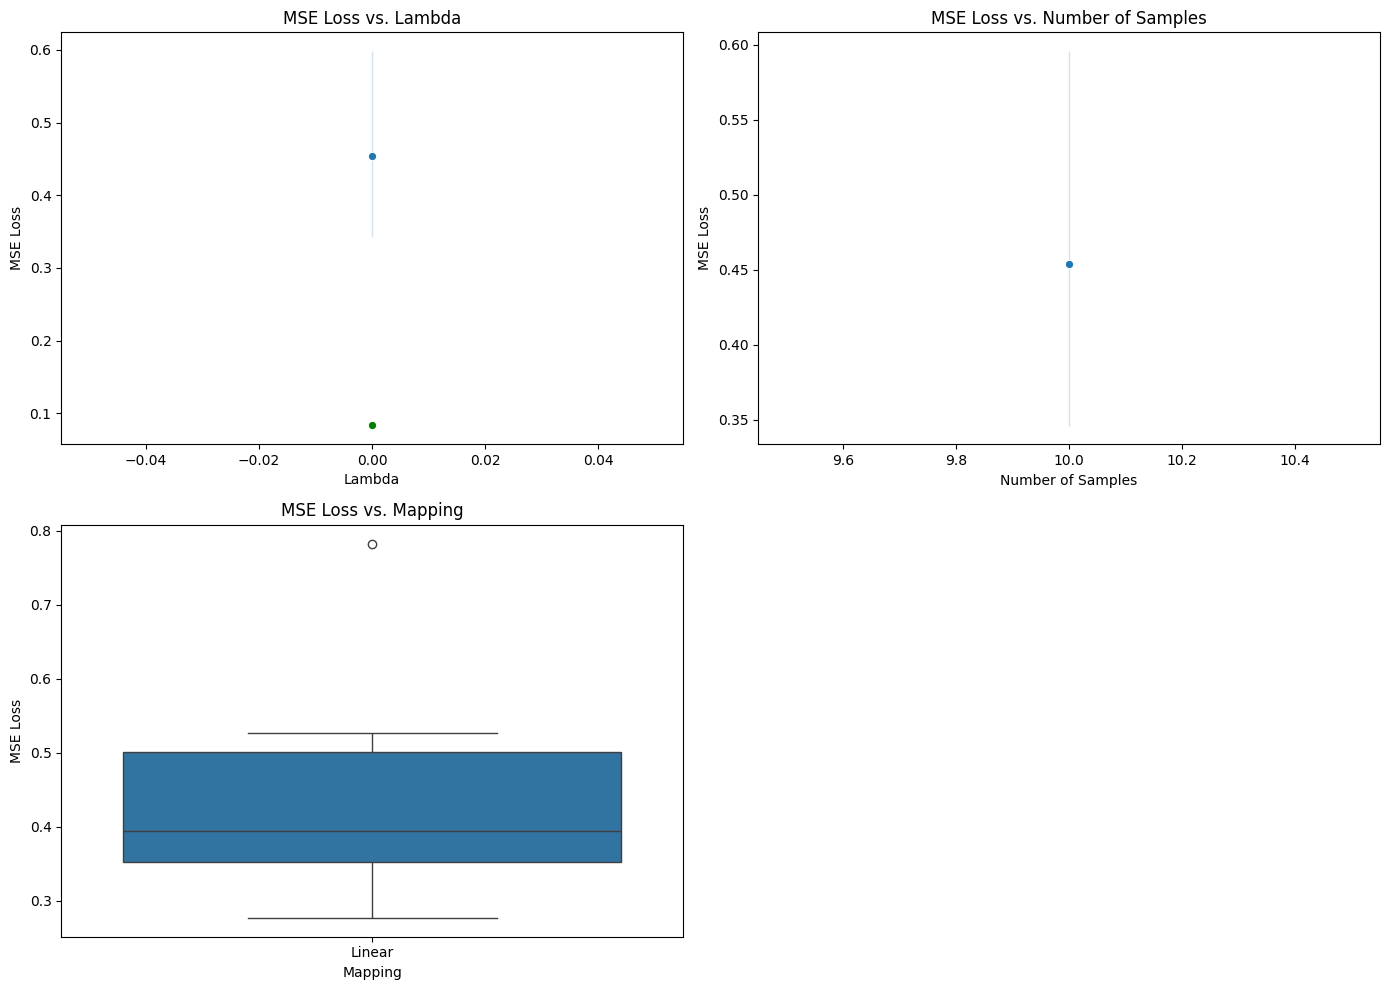

In [ ]:
# Filter where class is None
results = results[results['class'].isnull()]


# Plotting
plt.figure(figsize=(14, 10))

# Plot MSE_loss vs. lambda
plt.subplot(2, 2, 1)
sns.lineplot(data=results, x='lambda', y='MSE_loss', marker='o')
# Line at MSE_loss_model1 and MSE_loss_model2
sns.lineplot(data=results, x='lambda', y='MSE_loss_model1', marker='o', color='red')
sns.lineplot(data=results, x= 'lambda', y='MSE_loss_model2', marker='o', color='green')
plt.title('MSE Loss vs. Lambda')
plt.xlabel('Lambda')
plt.ylabel('MSE Loss')

# Plot MSE_loss vs. num_samples
plt.subplot(2, 2, 2)
sns.lineplot(data=results, x='num_samples', y='MSE_loss', marker='o')
plt.title('MSE Loss vs. Number of Samples')
plt.xlabel('Number of Samples')
plt.ylabel('MSE Loss')

# Plot MSE_loss vs. mapping (as a categorical variable)
plt.subplot(2, 2, 3)
sns.boxplot(data=results, x='mapping', y='MSE_loss')
plt.title('MSE Loss vs. Mapping')
plt.xlabel('Mapping')
plt.ylabel('MSE Loss')

# Plot MSE_loss vs. latent_dim_mod1
plt.subplot(2, 2, 4)
sns.lineplot(data=results, x='latent_dim_mod1', y='MSE_loss')
plt.title('MSE Loss vs. Latent Dimension Model 1')
plt.xlabel('Latent Dimension Model 1')
plt.ylabel('MSE Loss')


# Show all plots
plt.tight_layout()
plt.show()